Notes:
* Final Logistic Regression model
* Look into the fights that it judged wrongly - are they split dec? Any that are good?

In [1]:
# modeling
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn import metrics

df = pd.read_csv('every_ufc_fight_model_ready.csv')

In [2]:
filter_method = [
    'Decision - Unanimous',
    'Decision - Split',
    'Decision - Majority'
    ]

# select only decisions and 3 round fights
df_model = df[(df['method'].isin(filter_method)) & (df['number_of_rounds'] == 3)]

drop_cols = [
    'index',
    'date',
    'event_name',
    'first_fighter_name',
    'second_fighter_name',
    'method',
    'number_of_rounds'
    ]

df_model = df_model.drop(drop_cols, axis=1)
df_model = df_model.dropna(axis=1)

In [3]:
df_full = df_model.copy()

df_diff_first = df_model.filter(like='first').columns
df_diff_second = df_model.filter(like='second').columns

# create columns for the difference between first and second fighter stats
for index, value in enumerate(df_diff_first):
    base_col_name = df_diff_first[index].replace('first_fighter_', '')
    df_full[f'diff_{base_col_name}'] = df_full[df_diff_first[index]] - df_full[df_diff_second[index]]

In [49]:
# Normalize the data
columns_to_scale = df_full.columns.drop('winner')
scaler = StandardScaler()
df_full[columns_to_scale] = scaler.fit_transform(df_full[columns_to_scale])

X = df_full.drop('winner', axis=1)
y = df_full['winner'].astype('category')

# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Creating and training the model
model = LogisticRegression(max_iter=1000, penalty='l1', solver='liblinear')
model.fit(X_train, y_train)

# Testing the model
y_pred = model.predict(X_test)

# Evaluating the model
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))
print("Precision:", metrics.precision_score(y_test, y_pred))
print("Recall:", metrics.recall_score(y_test, y_pred))
print("F1 Score: ", metrics.f1_score(y_test, y_pred))

Accuracy: 0.8311258278145696
Precision: 0.8453947368421053
Recall: 0.8237179487179487
F1 Score:  0.8344155844155844


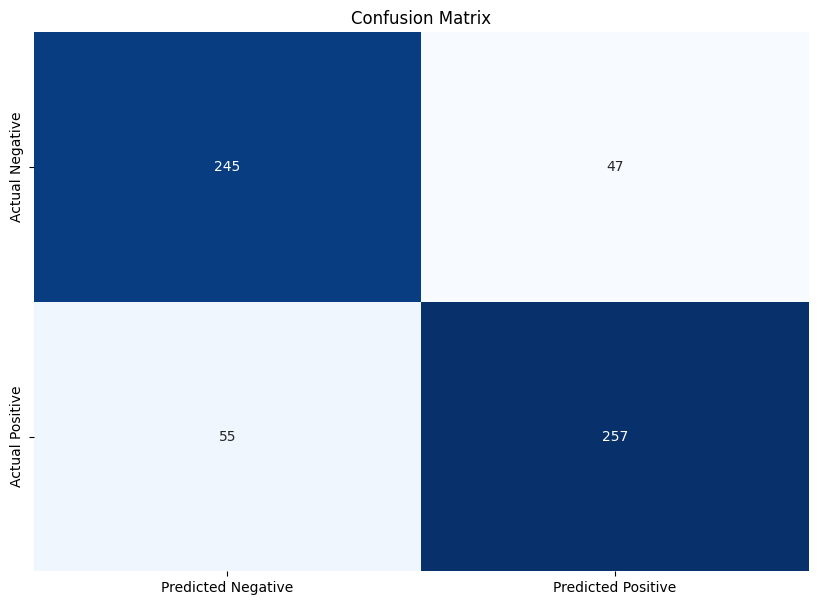

In [50]:
# Generate and print confusion matrix
cm = metrics.confusion_matrix(y_test, y_pred)
# Convert confusion matrix to a dataframe for better visualization
cm_df = pd.DataFrame(cm, columns=['Predicted Negative', 'Predicted Positive'],
                     index=['Actual Negative', 'Actual Positive'])

# Plot the heatmap
plt.figure(figsize=(10,7))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.show()

In [51]:
# Transform coefficients to odds ratios
odds_ratios = model.coef_

# Create a DataFrame for easy visualization
coef_df = pd.DataFrame({'features': X_train.columns, 'coef': odds_ratios[0]})
# Sort by coef value
coef_df = coef_df.sort_values('coef', ascending=False)

# Display the DataFrame
print(coef_df)

                                     features      coef
135                                  diff_STR  2.395882
136                                   diff_TD  1.130381
134                                   diff_KD  0.365471
73       second_fighter_round_1_LEG_attempted  0.356695
57   second_fighter_round_3_TOT_STR_attempted  0.347037
..                                        ...       ...
186             diff_round_2_CLINCH_attempted -0.194477
174             diff_round_1_CLINCH_attempted -0.210928
72          second_fighter_round_1_LEG_landed -0.273767
97       second_fighter_round_2_LEG_attempted -0.284191
83     first_fighter_round_1_GROUND_attempted -0.448759

[201 rows x 2 columns]
